In [ ]:
!pip install pandas matplotlib numpy scipy

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [5]:
np.random.seed(42)

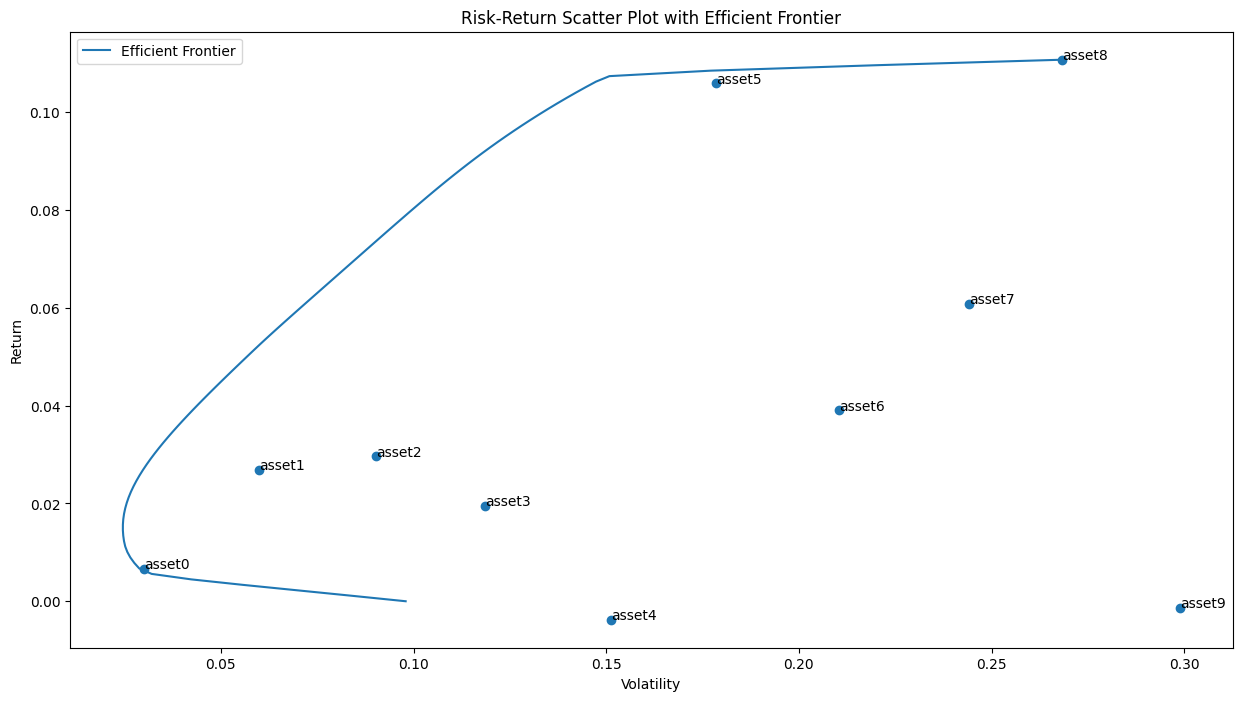

          return  volatility
asset0  0.006675    0.030187
asset1  0.026890    0.059835
asset2  0.029657    0.090290
asset3  0.019570    0.118593
asset4 -0.003778    0.151159
asset5  0.105948    0.178557
asset6  0.039099    0.210487
asset7  0.060836    0.244074
asset8  0.110762    0.268211
asset9 -0.001296    0.298804


In [6]:
class GeometricBrownianMotion:
    """Class for simulating Geometric Brownian Motion."""

    def __init__(self, mu: float, sigma: float, S0: float, dt: float, T: float):
        """
        Initialize the GeometricBrownianMotion object.

        Args:
            mu (float): Expected return.
            sigma (float): Volatility.
            S0 (float): Initial stock price.
            dt (float): Time increment.
            T (float): Final time.
        """
        self.mu = mu
        self.sigma = sigma
        self.S0 = S0
        self.dt = dt
        self.T = T

    def simulate(self) -> pd.DataFrame:
        """
        Simulate the Geometric Brownian Motion.

        Returns:
            pd.DataFrame: DataFrame containing the time and price paths.
        """
        N = int(self.T / self.dt)  # Number of time increments
        t = np.linspace(0, self.T, N + 1)  # Time vector
        W = np.cumsum(np.random.standard_normal(N + 1)) * np.sqrt(self.dt)  # Brownian increments
        S = self.S0 * np.exp((self.mu - 0.5 * self.sigma**2) * t + self.sigma * W)  # Geometric Brownian Motion
        return pd.DataFrame({"time": t, "price": S})


class EfficientFrontier:
    """Class for calculating the efficient frontier."""

    def __init__(self, assets, df, dt):
        """
        Initialize the EfficientFrontier object.

        Args:
            assets (list): List of asset parameters.
            df (pd.DataFrame): DataFrame containing the asset price paths.
            dt (float): Time increment.
        """
        self.assets = assets
        self.df = df
        self.dt = dt

    def portfolio_price(self, weights):
        return self.df[[asset["name"] for asset in self.assets]].mul(weights).sum(axis=1)

    def portfolio_volatility(self, weights):
        price = self.portfolio_price(weights)
        log_returns = np.log(price) - np.log(price.shift(1))
        log_returns.dropna(inplace=True)
        std = log_returns.std() * np.sqrt(1 / self.dt)
        return std

    def portfolio_return(self, weights):
        price = self.portfolio_price(weights)
        log_returns = np.log(price) - np.log(price.shift(1))
        log_returns.dropna(inplace=True)
        annual_return = log_returns.mean() / self.dt
        return annual_return

    def calculate_efficient_frontier(self, summary):
        num_assets = len(self.assets)
        weights = (1 / num_assets) * np.ones(num_assets)
        bnds = tuple((0, 1) for _ in range(num_assets))
        min_cagr, max_cagr = max(summary["return"].min(), 0), summary["return"].max()
        target_cagr_list = np.linspace(min_cagr, max_cagr, 100)
        volatilities = []
        for target_cagr in target_cagr_list:
            constraints = [
                {"type": "eq", "fun": lambda weights: np.sum(weights) - 1},
                {
                    "type": "eq",
                    "fun": lambda weights: self.portfolio_return(weights) - target_cagr,
                },
            ]
            result = minimize(
                self.portfolio_volatility,
                weights,
                method="SLSQP",
                bounds=bnds,
                constraints=constraints,
            )
            volatilities.append(result["fun"])
        volatilities = np.array(volatilities)
        return volatilities, target_cagr_list


def generate_asset_params(num_assets: int, mu_base: float, sigma_base: float) -> list:
    """
    Generate asset parameters for multiple assets.

    Args:
        num_assets (int): Number of assets to generate.
        mu_base (float): Base value for expected return.
        sigma_base (float): Base value for volatility.

    Returns:
        list: List of dictionaries containing asset parameters.
    """
    return [
        {
            "name": f"asset{i}",
            "param": {
                "mu": mu_base * (i + 1),
                "sigma": sigma_base * (i + 1),
                "S0": 100,
                "dt": 1 / 252,
                "T": 30,
            },
        }
        for i in range(num_assets)
    ]


def simulate_assets(assets: list) -> pd.DataFrame:
    """
    Simulate multiple assets using Geometric Brownian Motion.

    Args:
        assets (list): List of dictionaries containing asset parameters.

    Returns:
        pd.DataFrame: DataFrame containing the price paths of multiple assets.
    """
    df = pd.DataFrame()
    for asset in assets:
        gbm = GeometricBrownianMotion(**asset["param"])
        df[asset["name"]] = gbm.simulate()["price"]
    return df


def calculate_risk_return(price: pd.Series) -> tuple:
    """
    Calculate the annual return and volatility of an asset.

    Args:
        price (pd.Series): Price series of the asset.

    Returns:
        tuple: Annual return and volatility as a tuple.
    """
    log_returns = np.log(price) - np.log(price.shift(1))
    log_returns.dropna(inplace=True)
    annual_return = log_returns.mean() * 252
    annual_volatility = log_returns.std() * np.sqrt(252)
    return annual_return, annual_volatility


def calculate_summary(df, dt):
    log_returns = np.log(df) - np.log(df.shift(1))
    summary = pd.DataFrame(
        {
            "return": log_returns.mean() / dt,
            "volatility": log_returns.std() * np.sqrt(1 / dt),
        }
    )
    return summary


def main():
    """Main function to run the simulation."""
    mu_base = 0.01
    sigma_base = 0.03
    num_assets = 10
    dt = 1 / 252

    assets = generate_asset_params(num_assets, mu_base, sigma_base)
    df = simulate_assets(assets)

    # Calculate summary
    summary = calculate_summary(df, dt)

    # Calculate efficient frontier
    ef = EfficientFrontier(assets, df, dt)
    volatilities, target_cagr_list = ef.calculate_efficient_frontier(summary)

    # Plot risk-return scatter plot and efficient frontier
    plt.figure(figsize=(15, 8))
    plt.scatter(summary["volatility"], summary["return"])
    for i in summary.index:
        plt.annotate(i, (summary["volatility"][i], summary["return"][i]))
    plt.xlabel("Volatility")
    plt.ylabel("Return")
    plt.plot(volatilities, target_cagr_list, label="Efficient Frontier")
    plt.legend()
    plt.title("Risk-Return Scatter Plot with Efficient Frontier")
    plt.show()

    print(summary)


if __name__ == "__main__":
    main()